In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [20]:
n_clusters = 5
n_samples = n_clusters * 200
viridis_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

def generate_data(n_clusters=n_clusters,
                  n_samples=n_clusters*200,
                  dataset='type_1',
                  std=1.5,
                  seed=2023):
    if dataset=='type_1':
        X, y = make_blobs(
            n_samples=n_samples,
            centers=n_clusters, cluster_std=std, random_state=seed
        )
    elif dataset=='type_2':
        X, y = make_blobs(
            n_samples=n_samples,
            centers=((-5, 5), (5, 5), (0, 0), (-5, -5), (5, -5)),
            cluster_std=1.5, random_state=2023
        )
    else:
        print("WRONG DATASET")
        return
    return X, y

def split_data(X, y, train_ratio=0.6):
    '''
    Train-Test data split: Assume that the label distribution is i.i.d
    '''
    N = X.shape[0]
    idx = int(N*train_ratio)
    return X[:idx], X[idx:], y[:idx], y[idx:]

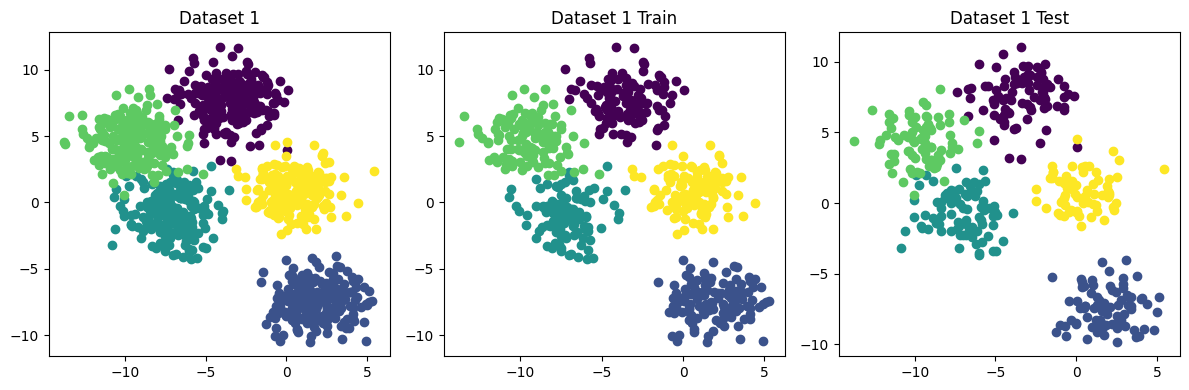

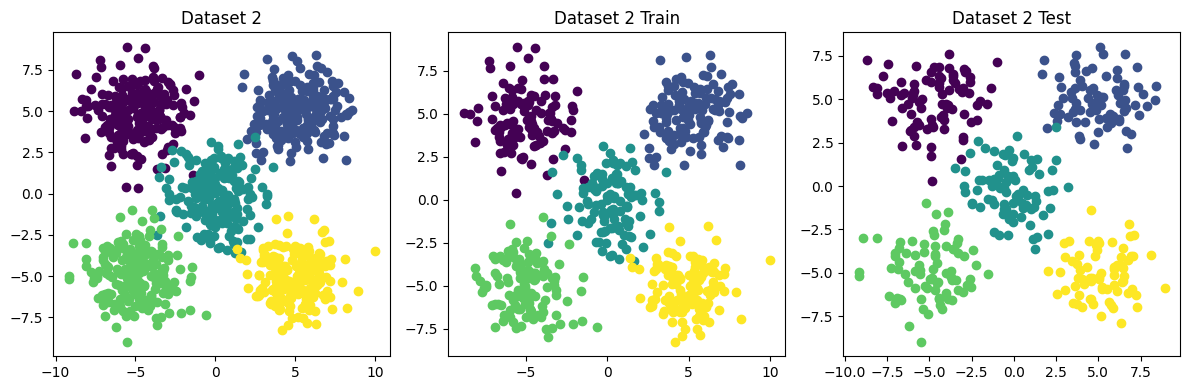

In [21]:
datasets = ['type_1', 'type_2']
for dataset in datasets:
    X, y = generate_data(dataset=dataset)
    X_train, X_test, y_train, y_test = split_data(X, y, 0.6)
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    for i in range(n_clusters):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]}')
    plt.subplot(1,3,2)
    for i in range(n_clusters):
        plt.scatter(X_train[y_train == i, 0], X_train[y_train == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]} Train')
    plt.subplot(1,3,3)
    for i in range(n_clusters):
        plt.scatter(X_test[y_test == i, 0], X_test[y_test == i, 1], color=viridis_colors[i],)
    plt.title(f'Dataset {dataset.split("_")[-1]} Test')
    plt.tight_layout()
    plt.show()

In [22]:
def one_hot(y, n_class=5):
    '''
    label to one-hot vector
    '''
    identity = np.eye(n_class)
    one_hot_y = identity[y]
    return one_hot_y

def softmax(z):
    '''
    Softmax function
    '''
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def NLL(y, S):
    '''
    NLL Loss
    '''
    N = S.shape[0]
    return -np.sum(y*np.log(S))/N

def accuracy(y_pred, y_true):
    '''
    Accuracy Function
    '''
    assert y_pred.shape[0]==y_true.shape[0], 'y_pred and y_true should have same number of element!'
    N = y_pred.shape[0]
    y_pred = np.argmax(y_pred, axis=1)
    return np.count_nonzero(y_pred==y_true)/N

In [23]:
class Classifier(object):
    def __init__(self, n_class=5):
        self.n_class = n_class
        self.W  = np.random.randn(2, n_class)
        self.B  = np.random.randn(n_class,)
        
    def train(self, X, y, lr=0.5):
        '''
        Logistic Regression
        '''
        y_      = one_hot(y)    # vectorize labels
        N       = X.shape[0]    # Number of Samples
        A       = X.dot(self.W) + self.B # a = WX+b
        S       = softmax(A)             # s = a
        loss    = NLL(y_, S)             # calculate NLL loss
        self.W -= lr*X.transpose(1,0).dot((S-y_))/N    # Gradient Descent to Weight W
        self.B -= lr*np.sum(S-y_, axis=0)/N            # Gradient Descent to Weight W
        return loss
    
    def fit(self, X, y, lr=0.1, iter=100, threshold=0.5, verbose=False):
        '''
        Fitting function
        X: input data
        y: labels
        lr: learning rate
        iter: number of iterations
        threshold: threshold for convergence
        verbose: Print training info if True        
        '''
        for i in range(iter):
            loss = self.train(X, y, lr)
            if verbose and i%10 == 0:
                print(f'{i:03}/{iter} NLL:{loss:.4f}')
            if loss < threshold:
                print(f'{i:03}/{iter} Loss < {threshold}! exit...')
                break
            
    def predict(self, X, prob=False):
        '''
        Predict function
        X: input data
        prob: return probability if True else return scalar label
        '''
        A    = X.dot(self.W) + self.B
        S    = softmax(A)
        if prob:
            return S
        else:
            return np.argmax(S, axis=1)
    
    def infer(self, X, y):
        '''
        Infer function
        Calculate & Print loss and accuracy
        X: input data
        y: labels
        '''
        y_   = one_hot(y)
        pred = self.predict(X, prob=True)
        loss = NLL(y_, pred)
        acc  = accuracy(pred, y)
        print(f'Test Loss: {loss:.4f} | Test Acc:{acc*100:.2f}')
    
    def plot_decision_boundary(self, X, y):
        '''
        Plot decision boundary of given model
        '''
        grid_size = 500
        A, B = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), grid_size),
                        np.linspace(X[:, 1].min(), X[:, 1].max(), grid_size))
        C = self.predict(np.hstack([A.reshape(-1, 1), B.reshape(-1, 1)])).reshape(grid_size, grid_size)
        plt.contourf(A, B, C, alpha=0.3, cmap=plt.cm.viridis)
        for i in range(n_clusters):
            plt.scatter(X[y == i, 0], X[y == i, 1], color=viridis_colors[i],)
        plt.title('Decision Boundary')
        plt.show()

000/1000 NLL:3.6509
010/1000 NLL:0.7310
020/1000 NLL:0.1861
030/1000 NLL:0.1557
040/1000 NLL:0.1369
050/1000 NLL:0.1236
060/1000 NLL:0.1137
070/1000 NLL:0.1061
080/1000 NLL:0.1000
090/1000 NLL:0.0951
100/1000 NLL:0.0911
110/1000 NLL:0.0876
120/1000 NLL:0.0847
130/1000 NLL:0.0821
140/1000 NLL:0.0797
150/1000 NLL:0.0777
160/1000 NLL:0.0758
170/1000 NLL:0.0741
180/1000 NLL:0.0725
190/1000 NLL:0.0710
200/1000 NLL:0.0697
210/1000 NLL:0.0684
220/1000 NLL:0.0673
230/1000 NLL:0.0661
240/1000 NLL:0.0651
250/1000 NLL:0.0641
260/1000 NLL:0.0632
270/1000 NLL:0.0623
280/1000 NLL:0.0615
290/1000 NLL:0.0607
300/1000 NLL:0.0599
310/1000 NLL:0.0592
320/1000 NLL:0.0585
330/1000 NLL:0.0579
340/1000 NLL:0.0572
350/1000 NLL:0.0566
360/1000 NLL:0.0560
370/1000 NLL:0.0555
380/1000 NLL:0.0549
390/1000 NLL:0.0544
400/1000 NLL:0.0539
410/1000 NLL:0.0534
420/1000 NLL:0.0530
430/1000 NLL:0.0525
440/1000 NLL:0.0521
450/1000 NLL:0.0516
460/1000 NLL:0.0512
470/1000 NLL:0.0508
480/1000 NLL:0.0504
490/1000 NLL:0.0501


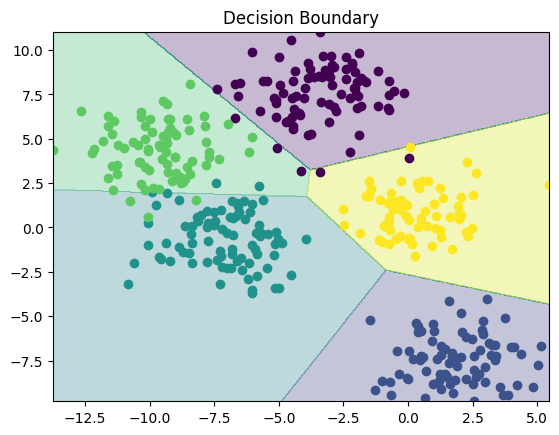

000/1000 NLL:8.1763
010/1000 NLL:0.2339
020/1000 NLL:0.1779
030/1000 NLL:0.1483
040/1000 NLL:0.1294
050/1000 NLL:0.1163
060/1000 NLL:0.1066
070/1000 NLL:0.0990
080/1000 NLL:0.0931
090/1000 NLL:0.0882
100/1000 NLL:0.0841
110/1000 NLL:0.0806
120/1000 NLL:0.0777
130/1000 NLL:0.0751
140/1000 NLL:0.0728
150/1000 NLL:0.0708
160/1000 NLL:0.0691
170/1000 NLL:0.0674
180/1000 NLL:0.0660
190/1000 NLL:0.0647
200/1000 NLL:0.0635
210/1000 NLL:0.0624
220/1000 NLL:0.0613
230/1000 NLL:0.0604
240/1000 NLL:0.0595
250/1000 NLL:0.0587
260/1000 NLL:0.0580
270/1000 NLL:0.0573
280/1000 NLL:0.0566
290/1000 NLL:0.0560
300/1000 NLL:0.0554
310/1000 NLL:0.0548
320/1000 NLL:0.0543
330/1000 NLL:0.0538
340/1000 NLL:0.0533
350/1000 NLL:0.0529
360/1000 NLL:0.0525
370/1000 NLL:0.0521
380/1000 NLL:0.0517
390/1000 NLL:0.0513
400/1000 NLL:0.0510
410/1000 NLL:0.0506
420/1000 NLL:0.0503
430/1000 NLL:0.0500
440/1000 NLL:0.0497
450/1000 NLL:0.0494
460/1000 NLL:0.0491
470/1000 NLL:0.0489
480/1000 NLL:0.0486
490/1000 NLL:0.0484


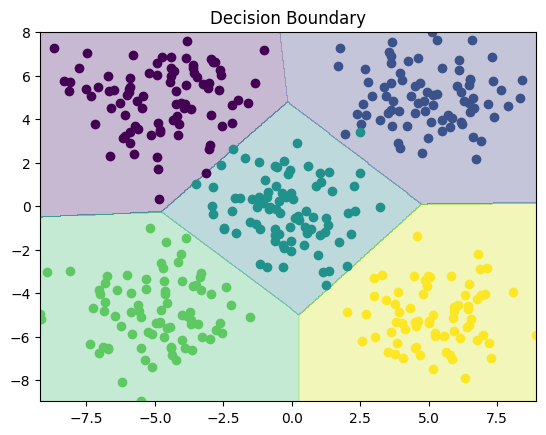

In [24]:
datasets = ['type_1', 'type_2']
for dataset in datasets:
    X, y = generate_data(dataset=dataset)
    X_train, X_test, y_train, y_test = split_data(X, y, 0.6)
    clf = Classifier()
    clf.fit(X_train, y_train, lr=0.5, threshold=0.001, iter=1000, verbose=True)
    clf.infer(X_test, y_test)
    clf.plot_decision_boundary(X_test, y_test)